install dependencies

In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/f0/e8/1ea9adebdccaadfc208c7517e09f5145ed5a73069779ff436393085d47a2/numpy-1.24.3-cp311-cp311-win_amd64.whl.metadata
Using cached numpy-1.24.3-cp311-cp311-win_amd64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\~umpy.libs\\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-2bde3a66a51006b2b53eb373ff767a3f.dll'
Consider using the `--user` option or check the permissions.



In [1]:
import os
import time
import uuid
import cv2

In [6]:
images_path = os.path.join('data', 'images')
number_images = 30

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(images_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()   

In [8]:
!labelme

C:\Users\User\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
2024-01-30 01:06:24,539 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\User\.labelmerc


REVIEW DATASET AND BUILD IMAGE LOADING PIPELINE

Import Necessary Lib

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

Load Image into TF data pipeline

In [3]:
my_dataset = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [ ]:
my_dataset.as_numpy_iterator().next()

In [4]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    return img

In [6]:
my_dataset = my_dataset.map(load_image) 

In [7]:
my_dataset.as_numpy_iterator().next()

array([[[147, 187, 176],
        [146, 188, 176],
        [144, 188, 175],
        ...,
        [ 95, 100,  93],
        [ 84,  95,  87],
        [ 76,  89,  82]],

       [[148, 188, 177],
        [148, 188, 177],
        [145, 189, 176],
        ...,
        [ 87,  94,  86],
        [ 80,  91,  83],
        [ 81,  94,  87]],

       [[151, 189, 176],
        [149, 190, 176],
        [148, 190, 176],
        ...,
        [ 78,  88,  79],
        [ 74,  87,  78],
        [ 76,  92,  82]],

       ...,

       [[ 87,  91,  90],
        [ 85,  89,  88],
        [ 89,  90,  92],
        ...,
        [ 80,  87,  95],
        [ 91,  98, 108],
        [136, 145, 154]],

       [[ 85,  91,  89],
        [ 88,  92,  91],
        [ 91,  92,  94],
        ...,
        [ 79,  86,  94],
        [ 87,  94, 104],
        [117, 124, 134]],

       [[ 86,  92,  90],
        [ 89,  95,  93],
        [ 89,  90,  92],
        ...,
        [ 81,  86,  92],
        [ 87,  94, 104],
        [102, 109, 119]]

In [8]:
type(my_dataset)

tensorflow.python.data.ops.map_op._MapDataset

View raw images with matplotlib

In [6]:
my_dataset_generator = my_dataset.batch(4).as_numpy_iterator()

NameError: name 'my_dataset' is not defined

In [10]:
plot_images = my_dataset_generator.next()

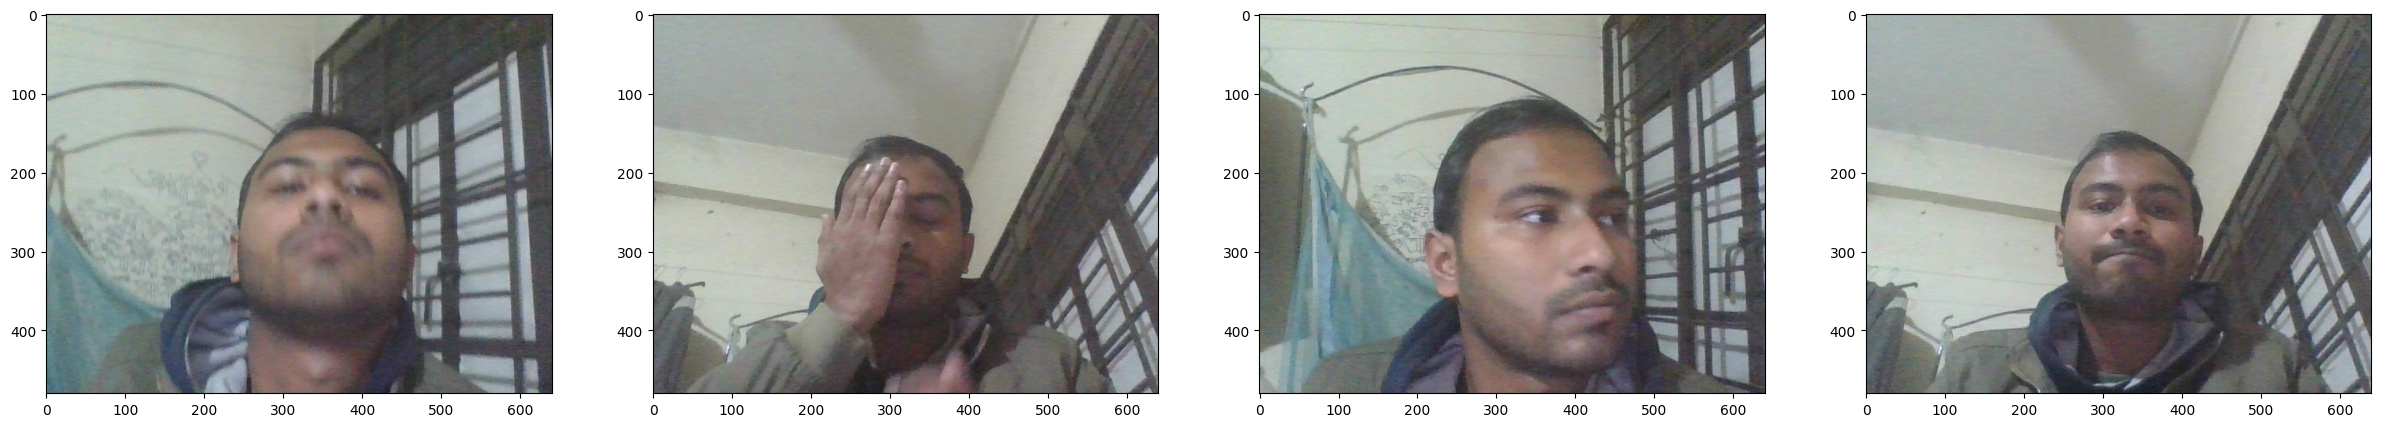

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(30,30))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

PARTITION UNAUGMENTED DATA

1.manually split data into train test validation

In [14]:
90 * .7 # 63 images for train
90 * .15 # 14 and 13 for test and val

13.5

make matching labels

In [16]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

Apply Image Augmentation on Images and Labels using Albumentation

1.setup albumentation transform pipeline

In [4]:
import albumentations as alb

In [5]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

Load a Test Image and Annotation with OpenCV and JSON

In [8]:


img = cv2.imread(os.path.join('data','train', 'images','238ff628-be18-11ee-a849-c46516a8c3cf.jpg'))

In [9]:
img

array([[[179, 171, 172],
        [179, 171, 172],
        [177, 170, 173],
        ...,
        [ 94,  83,  79],
        [ 95,  84,  76],
        [ 96,  84,  74]],

       [[179, 171, 171],
        [177, 171, 172],
        [177, 171, 172],
        ...,
        [ 94,  83,  79],
        [ 96,  83,  75],
        [ 96,  84,  74]],

       [[174, 169, 166],
        [173, 170, 166],
        [174, 170, 169],
        ...,
        [ 84,  71,  69],
        [ 90,  76,  70],
        [ 98,  82,  75]],

       ...,

       [[103,  97,  92],
        [100,  94,  89],
        [102,  93,  90],
        ...,
        [101,  89,  89],
        [104,  90,  91],
        [115, 102, 100]],

       [[108, 104,  99],
        [104, 100,  95],
        [102,  95,  92],
        ...,
        [ 97,  85,  85],
        [101,  87,  88],
        [106,  90,  91]],

       [[ 99,  95,  90],
        [ 94,  90,  85],
        [ 94,  87,  84],
        ...,
        [ 96,  83,  85],
        [ 97,  83,  84],
        [ 95,  79,  80]]

In [10]:


with open(os.path.join('data', 'train', 'labels', '238ff628-be18-11ee-a849-c46516a8c3cf.json'), 'r') as f:
    label = json.load(f)

In [22]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[248.45528455284557, 170.89430894308944],
    [431.3821138211382, 363.5772357723577]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\238ff628-be18-11ee-a849-c46516a8c3cf.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVY

In [26]:
label['shapes'][0]['points']

[[248.45528455284557, 170.89430894308944],
 [431.3821138211382, 363.5772357723577]]

 Extract Coordinates and Rescale to Match Image Resolution

In [13]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [14]:
coords

[248.45528455284557, 170.89430894308944, 431.3821138211382, 363.5772357723577]

In [15]:
coords = list(np.divide(coords, [640,480,640,480]))

In [16]:
coords

[0.3882113821138212, 0.356029810298103, 0.6740345528455285, 0.7574525745257452]

Apply Augmentations and View Results

In [17]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [18]:
augmented['bboxes'][0][2:]

(0.6612104787714543, 0.752393857271906)

In [19]:
augmented['bboxes']

[(0.25470641373080394,
  0.3242095754290876,
  0.6612104787714543,
  0.752393857271906)]

In [4]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

NameError: name 'augmented' is not defined

 Build and Run Augmentation Pipeline

1.Run Augmentation Pipeline

In [27]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Load Augmented Images to Tensorflow Dataset

In [5]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [6]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [7]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

Prepare Labels

Build Label Loading Function

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

Load labels to tensorflow dataset

In [9]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

Combine Label and Image Samples

Check Partition Lengths

In [14]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 780, 780, 840, 840)

Create Final Datasets (Images/Labels)

In [12]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [13]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [14]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [18]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

View Images and Annotations

In [15]:
res =train.as_numpy_iterator().next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


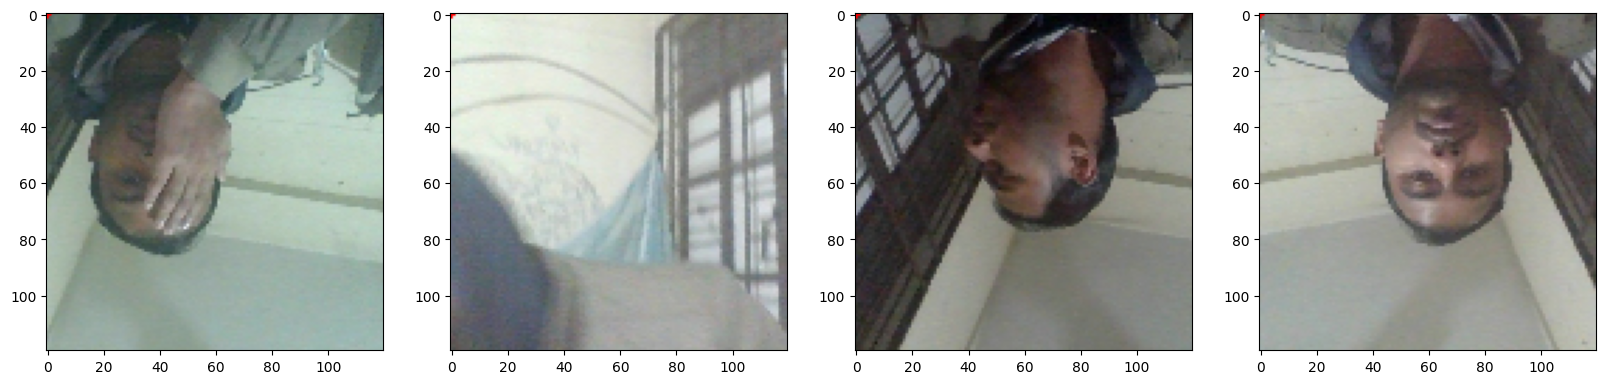

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    # Make a copy of the image to avoid modifying the original data
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]

    # Convert coordinates to integers
    coords_int = sample_coords.astype(int)

    # Draw rectangle on the image
    cv2.rectangle(sample_image,
                  tuple(np.multiply(coords_int[:2], [120, 120])),
                  tuple(np.multiply(coords_int[2:], [120, 120])),
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_image)




Build Deep Learning using the Functional API

Import Layers and Base Network

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [24]:
vgg = VGG16(include_top=False)

In [25]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Build instance of Network

In [26]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [27]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.2015, 0.1882, 0.7075, 0.705 ],
        [0.093 , 0.2119, 0.756 , 0.9272],
        [0.    , 0.3032, 0.3608, 0.9014],
        [0.1017, 0.2474, 0.7646, 0.963 ],
        [0.641 , 0.2054, 1.    , 0.9243],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.1716, 0.4343, 0.609 ],
        [0.3071, 0.    , 0.914 , 0.6904]], dtype=float16))

Test out Neural Network

In [28]:
facetracker = build_model()

In [29]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [30]:
X, y = train.as_numpy_iterator().next()

In [31]:
X.shape

(8, 120, 120, 3)

In [32]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [33]:
classes, coords

(array([[0.5523142 ],
        [0.5292777 ],
        [0.572574  ],
        [0.5882141 ],
        [0.5220031 ],
        [0.49328062],
        [0.52382255],
        [0.4803677 ]], dtype=float32),
 array([[0.46902433, 0.6003567 , 0.5465092 , 0.4186232 ],
        [0.39489305, 0.5978378 , 0.62837255, 0.5086361 ],
        [0.40035203, 0.57414687, 0.5560372 , 0.47169954],
        [0.47729236, 0.55273914, 0.61018634, 0.5124291 ],
        [0.46857634, 0.603618  , 0.50355655, 0.45106485],
        [0.49647683, 0.5950781 , 0.5814478 , 0.41044727],
        [0.4306803 , 0.6038226 , 0.59365284, 0.421928  ],
        [0.42288303, 0.55044806, 0.59700197, 0.40934497]], dtype=float32))

Define Losses and Optimizers

Define Optimizer and LR

In [38]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [39]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

Create Localization Loss and Classification Loss

In [40]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [41]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

Test out Loss Metrics

In [42]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.6646805>

In [44]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.658416>

In [45]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.6646805>

Train Neural Network

Create custom Model Class

In [50]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)
        

In [24]:
model = FaceTracker(facetracker)

NameError: name 'FaceTracker' is not defined

model.compile(opt, classloss, regressloss)

Train

In [53]:
logdir='logs'

In [54]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [55]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 860s 2s/step - total_loss: 0.2685 - class_loss: 0.0482 - regress_loss: 0.2445 - val_total_loss: 0.1136 - val_class_loss: 5.7596e-04 - val_regress_loss: 0.1133
Epoch 2/10
473/473 [==============================] - 817s 2s/step - total_loss: 0.0344 - class_loss: 2.4644e-04 - regress_loss: 0.0343 - val_total_loss: 0.1670 - val_class_loss: 1.5662e-05 - val_regress_loss: 0.1670
Epoch 3/10
473/473 [==============================] - 819s 2s/step - total_loss: 0.0234 - class_loss: 8.5860e-05 - regress_loss: 0.0234 - val_total_loss: 0.0671 - val_class_loss: 1.2089e-04 - val_regress_loss: 0.0670
Epoch 4/10
473/473 [==============================] - 829s 2s/step - total_loss: 0.0146 - class_loss: 3.7908e-05 - regress_loss: 0.0146 - val_total_loss: 0.1636 - val_class_loss: 1.9648e-05 - val_regress_loss: 0.1636
Epoch 5/10
473/473 [==============================] - 833s 2s/step - total_loss: 0.0134 - class_loss: 2.8240e-05 - regress_loss: 0.0134 

In [56]:
hist.history

{'total_loss': [0.02261572889983654,
  0.01182351354509592,
  0.005113625433295965,
  0.008538616821169853,
  0.005465287249535322,
  0.0016451055416837335,
  0.0054110316559672356,
  0.0023391074500977993,
  0.0029853954911231995,
  0.0026966126170009375],
 'class_loss': [0.000504263152834028,
  1.028182282425405e-06,
  6.26345063210465e-05,
  4.56588932138402e-05,
  9.983792779166833e-07,
  8.235387213062495e-05,
  4.8429164962726645e-06,
  5.364423714127042e-07,
  9.134572792390827e-06,
  1.0430814256778831e-07],
 'regress_loss': [0.02236359752714634,
  0.011822999455034733,
  0.005082308314740658,
  0.008515787310898304,
  0.005464788060635328,
  0.0016039286274462938,
  0.005408610217273235,
  0.00233883922919631,
  0.002980828285217285,
  0.002696560462936759],
 'val_total_loss': [0.11356228590011597,
  0.16704599559307098,
  0.06710217893123627,
  0.16356925666332245,
  0.022136304527521133,
  0.014492743648588657,
  0.10494343936443329,
  0.04125247150659561,
  0.03157346695661

plot performance

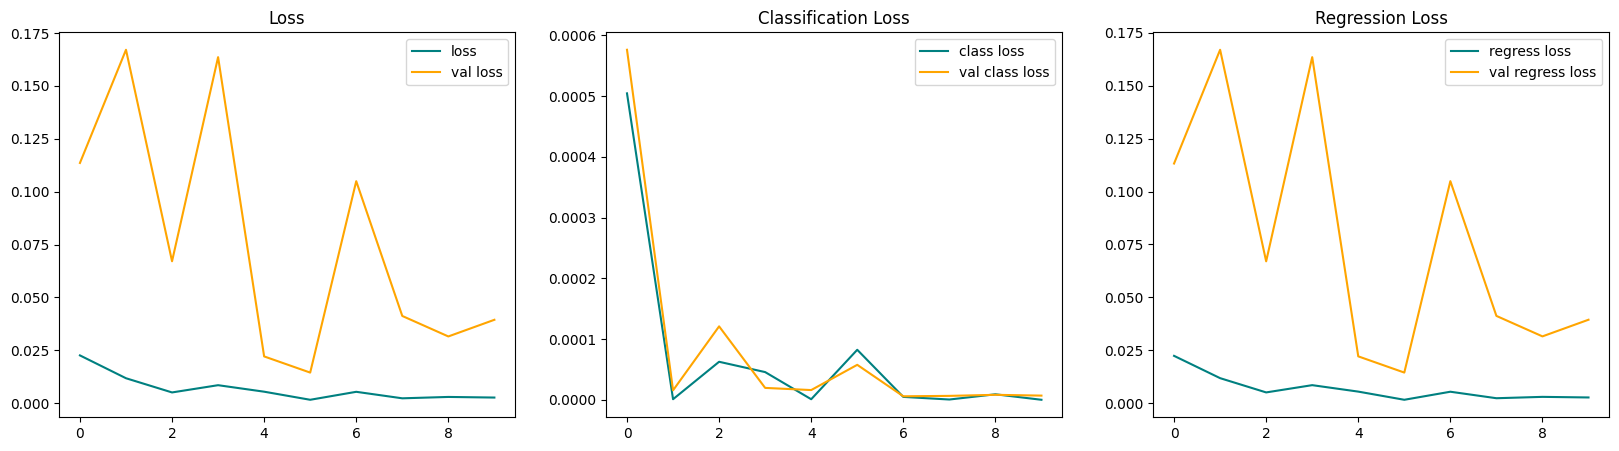

In [57]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

make predictions

In [58]:
test_data = test.as_numpy_iterator()

In [59]:
test_sample = test_data.next()

In [60]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 366ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


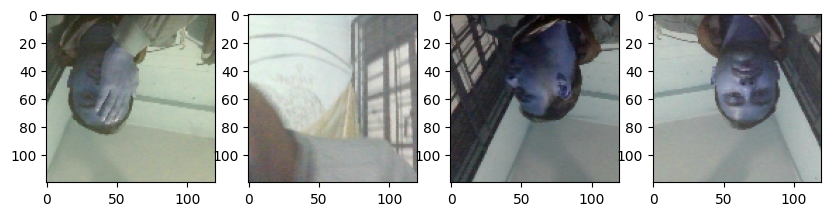

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(10, 10))
for idx in range(4): 
    sample_image = res[0][idx]  # No need to call .numpy() here
    sample_coords = res[1][1][idx]
    
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
    
    # Expand coordinates to (x1, y1, x2, y2) format
    x1, y1, x2, y2 = sample_coords
    coords_int = np.array([x1, y1, x2, y2], dtype=int)
    
    # Draw rectangle on the image
    cv2.rectangle(sample_image, tuple(coords_int[:2]), tuple(coords_int[2:]), (255, 0, 0), 2)

    ax[idx].imshow(sample_image)


save the model

In [1]:
from tensorflow.keras.models import load_model

In [23]:
facetracker.save('facetracker.h5')

NameError: name 'facetracker' is not defined

In [4]:
facetracker = load_model('facetracker.h5')

Real Time

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTracker', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 140ms/step
